# Análisis de Threshold y Gráficas — Modelo Baseline V3

Este notebook tiene como objetivo explorar el comportamiento del modelo baseline v3 (linearsvc calibrado) ajustando y evaluando distintos umbrales de decisión a partir de sus probabilidades sobre todo el dataset. Se busca entender la relación entre los scores de salida y las métricas relevantes para phishing, con el fin de seleccionar un threshold contractual óptimo.

> **Nota:** Este cuaderno es estrictamente exploratorio y NO exporta artefactos contractuales.

**Pasos que se abordarán:**
- Carga del modelo v3 y del dataset completo
- Obtención de probabilidades (scores) del modelo
- Generación de curva ROC
- Generación de curva Precision-Recall
- Análisis de la distribución de scores
- Tabla de métricas para varios thresholds
- Selección y justificación del umbral final contractual



In [1]:
# %%
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from scipy.special import expit

# 2. Carga del dataset contractual
DATASET_PATH = "../../../data/interim/dataset_v3_features.csv"
df = pd.read_csv(DATASET_PATH)

# 3. Definición de features v3 exacto
FEATURES_V3 = [
    "domain_complexity",
    "domain_whitelist",
    "trusted_token_context",
    "host_entropy",
    "infra_risk",
    "brand_in_path",
    "brand_match_flag"
]

# 4. Carga del modelo contractual baseline v3
model = joblib.load("../../../ml/models/logreg_phishing_v2.joblib")

# 5. Preparación de variables
X = df[FEATURES_V3]
y = df["label"]

print("Modelo contractual v3 y dataset cargados correctamente.")



Modelo contractual v3 y dataset cargados correctamente.


In [2]:
# %%
y_scores = model.predict_proba(X)[:, 1]

print("Rango de scores:")
print("  Mínimo:", np.min(y_scores))
print("  Máximo:", np.max(y_scores))

percentiles = np.percentile(y_scores, [5, 25, 50, 75, 95])
print("Percentiles:")
print("  5%:", percentiles[0])
print(" 25%:", percentiles[1])
print(" 50%:", percentiles[2])
print(" 75%:", percentiles[3])
print(" 95%:", percentiles[4])

print("Media:", np.mean(y_scores))
print("Desviación típica:", np.std(y_scores))

print("Probabilidades calculadas correctamente. Listas para ROC/PR.")



Rango de scores:
  Mínimo: 0.009223944681774903
  Máximo: 0.9998689358407151
Percentiles:
  5%: 0.009223944681774903
 25%: 0.0111652517260759
 50%: 0.542715887008228
 75%: 0.8714256502073524
 95%: 0.9992379606311244
Media: 0.49316362802757885
Desviación típica: 0.3976751768116028
Probabilidades calculadas correctamente. Listas para ROC/PR.


/opt/anaconda3/envs/phishing-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


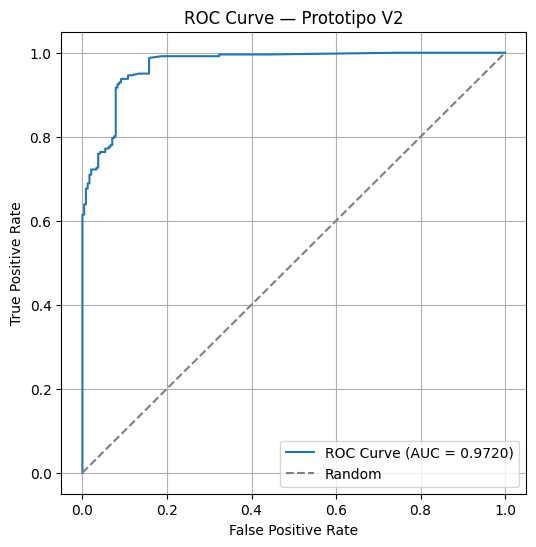

AUC: 0.972030440247241


In [3]:
# %%
from matplotlib import pyplot as plt

fpr, tpr, roc_thresholds = roc_curve(y, y_scores)
auc_value = roc_auc_score(y, y_scores)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_value:.4f})")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Prototipo V2")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("AUC:", auc_value)



/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_33053/1868417144.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc = np.trapz(precision, recall)


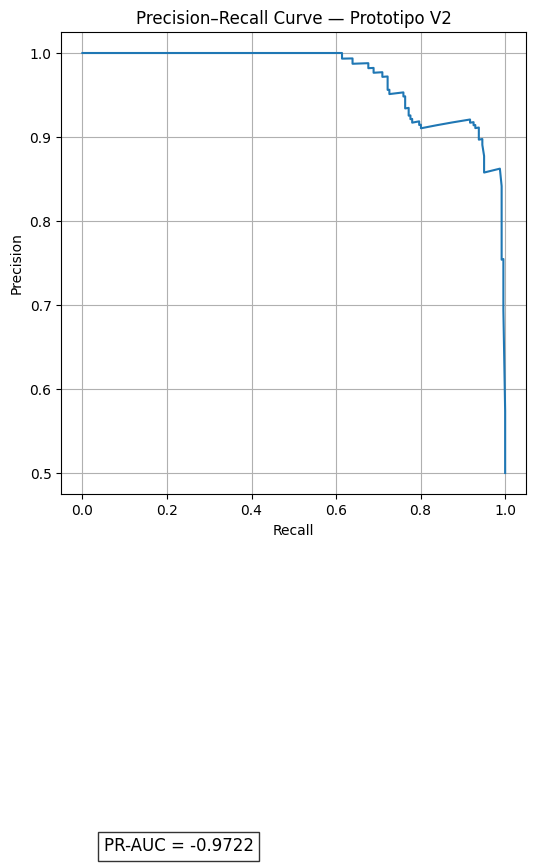

PR-AUC: -0.9721514916056437


In [4]:
# %%
precision, recall, pr_thresholds = precision_recall_curve(y, y_scores)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label="Prec-Rec Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Prototipo V2")
pr_auc = np.trapz(precision, recall)
plt.text(0.05, 0.05, f"PR-AUC = {pr_auc:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.grid(True)
plt.show()

print("PR-AUC:", pr_auc)



In [5]:
# %%
import numpy as np

# Corrección del cálculo del PR-AUC
order = np.argsort(recall)
pr_auc_corrected = np.trapz(precision[order], recall[order])

print("PR-AUC corregido:", pr_auc_corrected)


PR-AUC corregido: 0.9721078131482302


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_33053/3109142638.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pr_auc_corrected = np.trapz(precision[order], recall[order])


In [6]:
# %%
thresholds = np.arange(0.1, 1.0, 0.1)
rows = []
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    precision = np.sum((y_pred == 1) & (y == 1)) / max(np.sum(y_pred == 1), 1)
    recall = np.sum((y_pred == 1) & (y == 1)) / max(np.sum(y == 1), 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    tp = np.sum((y_pred == 1) & (y == 1))
    fp = np.sum((y_pred == 1) & (y == 0))
    tn = np.sum((y_pred == 0) & (y == 0))
    fn = np.sum((y_pred == 0) & (y == 1))
    fp_rate = fp / max(fp + tn, 1)
    tp_rate = tp / max(tp + fn, 1)
    rows.append({
        "threshold": round(threshold, 2),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fp_rate": fp_rate,
        "tp_rate": tp_rate
    })

df_thr = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "f1", "fp_rate", "tp_rate"])
print(df_thr)



   threshold  precision    recall        f1   fp_rate   tp_rate
0        0.1   0.747664  0.995851  0.854093  0.336100  0.995851
1        0.2   0.783607  0.991701  0.875458  0.273859  0.991701
2        0.3   0.807432  0.991701  0.890130  0.236515  0.991701
3        0.4   0.824138  0.991701  0.900188  0.211618  0.991701
4        0.5   0.897638  0.946058  0.921212  0.107884  0.946058
5        0.6   0.913242  0.829876  0.869565  0.078838  0.829876
6        0.7   0.921182  0.775934  0.842342  0.066390  0.775934
7        0.8   0.987500  0.655602  0.788030  0.008299  0.655602
8        0.9   1.000000  0.439834  0.610951  0.000000  0.439834


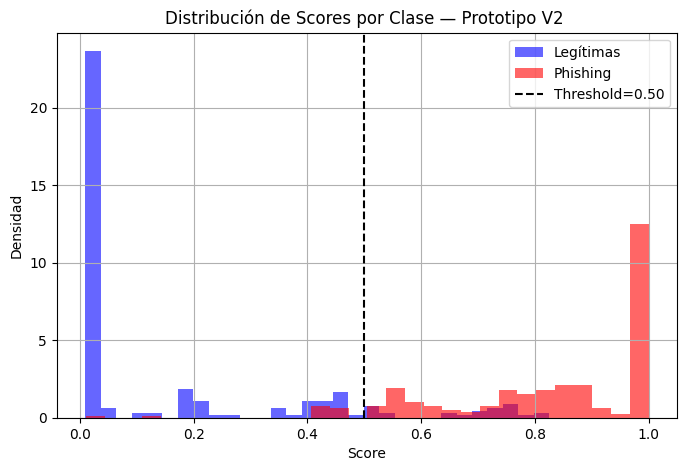

Histograma doble generado correctamente.


In [7]:
# %%
scores_legit = y_scores[y == 0]
scores_phish = y_scores[y == 1]

plt.figure(figsize=(8, 5))
plt.hist(scores_legit, bins=30, alpha=0.6, color="blue", density=True, label="Legítimas")
plt.hist(scores_phish, bins=30, alpha=0.6, color="red", density=True, label="Phishing")
plt.axvline(0.50, color="black", linestyle="--", label="Threshold=0.50")
plt.title("Distribución de Scores por Clase — Prototipo V2 ")
plt.xlabel("Score")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.show()

print("Histograma doble generado correctamente.")



In [8]:
# %%
# Definir threshold contractual
threshold = 0.50

# Predicción binaria
y_pred = (y_scores >= threshold).astype(int)

# Identificar FP y FN
fp_mask = (y == 0) & (y_pred == 1)
fn_mask = (y == 1) & (y_pred == 0)

fp_cases = df[fp_mask].copy()
fn_cases = df[fn_mask].copy()

print("Falsos Positivos (FP):", len(fp_cases))
print("Falsos Negativos (FN):", len(fn_cases))

fp_cases.head(10)


Falsos Positivos (FP): 26
Falsos Negativos (FN): 13


,url,label,sector,entidad,notas,campaign,domain_complexity,domain_whitelist,trusted_token_context,host_entropy,infra_risk,brand_in_path,brand_match_flag
93,https://help.twitter.com/es,0,redessociales,twitter,NaN,NaN,0.734953,0,-1,2.000000,0.0,0,0
110,https://academy.bit2me.com/es/,0,cripto,bit2me,NaN,NaN,0.790927,0,-1,2.521641,0.0,0,0
116,https://mygls.gls-spain.es/,0,logistica,gls espana,NaN,NaN,0.854735,0,-1,2.321928,0.0,0,0
127,https://account.microsoft.com/,0,saas,microsoft,NaN,NaN,0.862350,0,-1,2.521641,0.0,0,0
128,https://support.kraken.com/hc/es,0,cripto,kraken,NaN,NaN,0.744201,0,-1,2.521641,0.0,0,0
131,https://status.coinbase.com/,0,cripto,coinbase,NaN,NaN,0.861426,0,-1,1.918296,0.0,0,0
132,https://www.coinbase.com/es/learn,0,cripto,coinbase,NaN,NaN,0.861426,0,-1,-0.000000,0.0,0,0
133,https://accounts.coinbase.com/signin?lang=es,0,cripto,coinbase,NaN,NaN,0.861426,0,-1,2.750000,0.0,0,0
134,https://developers.binance.com/docs/wallet/oth...,0,cripto,binance,NaN,NaN,0.790410,0,-1,2.846439,0.0,0,0
139,https://accounts.binance.com/es/register,0,cripto,binance,NaN,NaN,0.790410,0,-1,2.750000,0.0,0,0


In [9]:
fn_cases.head(20)


,url,label,sector,entidad,notas,campaign,domain_complexity,domain_whitelist,trusted_token_context,host_entropy,infra_risk,brand_in_path,brand_match_flag
242,http://122.114.173.242:30/bancosantander.es/pa...,1,banca,santander,banca | santander | Login | marca_en_path;span...,NaN,0.000000,0,-1,0.000000,0.3,0,0
246,https://wififpt.com.vn/es/bankia.es/es/acceso-...,1,banca,bankia,banca | bankia | Login | marca_en_path;spanish...,NaN,0.775643,0,-1,0.000000,0.0,0,0
368,https://serviciodecorreo.es/,1,logistica,serviciodecorreo,.es + castellano (“servicio de correo”) en dom...,serviciodecorreo.es,0.000000,1,1,0.000000,0.0,0,1
369,https://sites.google.com/view/habilitaciondeac...,1,saas,google,Phishing genérico + Google Sites gratuito + ke...,sites.google.com/view/habilitaciondeacceso/pág...,0.694940,0,0,1.921928,0.0,0,1
370,https://sites.google.com/view/serviciosexclusi...,1,saas,google,Phishing genérico + Google Sites gratuito + ke...,sites.google.com/view/serviciosexclusivos/pági...,0.694940,0,0,1.921928,0.0,0,1
396,https://sites.google.com/view/confirmaciondeda...,1,saas,google,Google Sitesgenérico en castellano (“confirmac...,sites.google.com/confirmaciondedatos,0.694940,0,0,1.921928,0.0,0,1
406,https://sites.google.com/view/ruraless/p%C3%A1...,1,saas,google,Caja Rural en Google Sites+ castellano → buen ...,sites.google.com/ruraless,0.694940,0,0,1.921928,0.0,0,1
425,https://robllox.com.es,1,gaming,roblox,typosquatting de Roblox + TLD .com.es (orienta...,robllox.com.es,0.775643,0,-1,0.000000,0.0,0,0
453,https://robiox.com.es,1,gaming,roblox,typosquatting de Roblox + .com.es (orientación...,robiox.com.es,0.769530,0,-1,0.000000,0.0,0,0
460,https://online.multa.net/,1,publico,dgt,DGT sin acortador; segundo flujo del mismo host,multa.net,0.418628,0,-1,2.251629,0.0,0,0


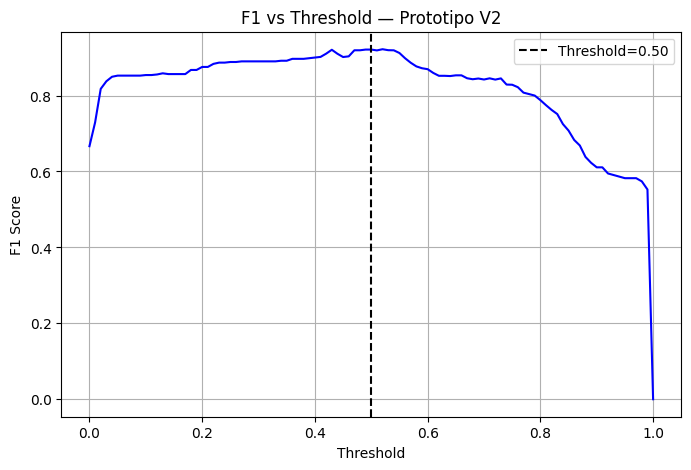

Punto máximo F1: 0.9221311475409836 en threshold: 0.52


In [10]:
# %%
thresholds = np.arange(0.0, 1.01, 0.01)
f1_values = []
thr_values = []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    f1 = f1_score(y, y_pred)
    f1_values.append(f1)
    thr_values.append(t)

plt.figure(figsize=(8, 5))
plt.plot(thr_values, f1_values, color="blue")
plt.axvline(0.50, color="black", linestyle="--", label="Threshold=0.50")
plt.title("F1 vs Threshold — Prototipo V2")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

print("Punto máximo F1:", max(f1_values), "en threshold:", thr_values[np.argmax(f1_values)])



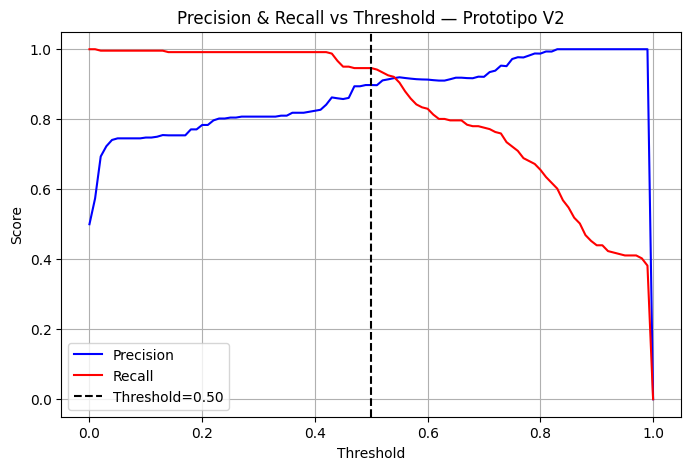

Precision @0.50: 0.8976377952755905
Recall @0.50: 0.946058091286307


In [11]:
# %%
thresholds = np.arange(0.0, 1.01, 0.01)
precision_values = []
recall_values = []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    precision_values.append(precision_score(y, y_pred, zero_division=0))
    recall_values.append(recall_score(y, y_pred, zero_division=0))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision_values, color="blue", label="Precision")
plt.plot(thresholds, recall_values, color="red", label="Recall")
plt.axvline(0.50, color="black", linestyle="--", label="Threshold=0.50")
plt.title("Precision & Recall vs Threshold — Prototipo V2")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

print("Precision @0.50:", precision_values[50])
print("Recall @0.50:", recall_values[50])



Metrics @0.50
Precision: 0.8976377952755905
Recall: 0.946058091286307
F1: 0.9212121212121213
Confusion Matrix:
[[215  26]
 [ 13 228]]


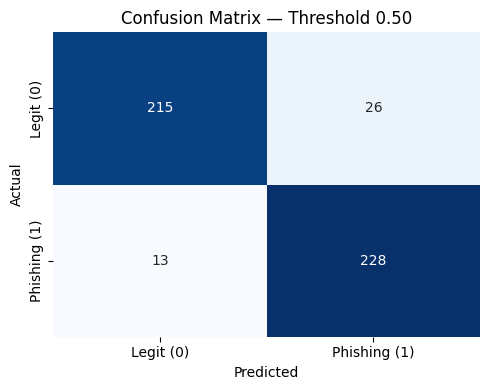

In [12]:
# %%
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aplicar threshold
threshold = 0.50
y_pred = (y_scores >= threshold).astype(int)

# 2. Calcular métricas
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
confusion = confusion_matrix(y, y_pred)

# 3. Imprimir resultados
print("Metrics @0.50")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Confusion Matrix:")
print(confusion)

# 4. Dibujo de la matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legit (0)', 'Phishing (1)'],
            yticklabels=['Legit (0)', 'Phishing (1)'])
plt.title("Confusion Matrix — Threshold 0.50")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

,feature,coef
0,domain_complexity,3.052163
4,infra_risk,2.278861
3,host_entropy,0.454669
6,brand_match_flag,0.192965
5,brand_in_path,0.105384
1,domain_whitelist,-0.369654
2,trusted_token_context,-0.868714


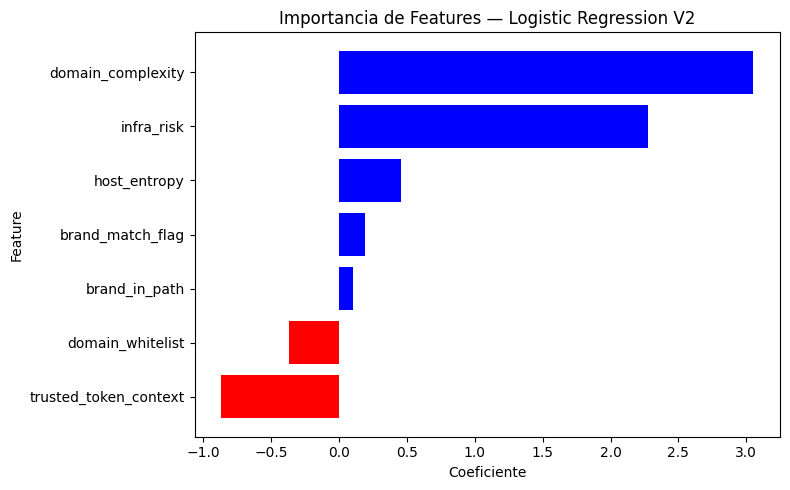

Features que más empujan hacia phishing (coef > 0):
             feature      coef
0  domain_complexity  3.052163
4         infra_risk  2.278861
3       host_entropy  0.454669
6   brand_match_flag  0.192965
5      brand_in_path  0.105384

Features que empujan hacia legítimo (coef < 0):
                 feature      coef
1       domain_whitelist -0.369654
2  trusted_token_context -0.868714


In [13]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extraer coeficientes
coef = model.coef_[0]

# 2. DataFrame ordenado
df_coef = pd.DataFrame({
    "feature": FEATURES_V3,
    "coef": coef
}).sort_values("coef", ascending=False)

# 3. Mostrar DataFrame
display(df_coef)

# 4. Gráfico de barras horizontal con color por signo
plt.figure(figsize=(8, 5))
colors = df_coef['coef'].apply(lambda x: 'blue' if x > 0 else 'red')
plt.barh(df_coef['feature'], df_coef['coef'], color=colors)
plt.title("Importancia de Features — Logistic Regression V2")
plt.xlabel("Coeficiente")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Valoración automática
print("Features que más empujan hacia phishing (coef > 0):")
print(df_coef[df_coef['coef'] > 0])
print("\nFeatures que empujan hacia legítimo (coef < 0):")
print(df_coef[df_coef['coef'] < 0])